In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

K-Means算法是一种聚类方法，它因速度和稳定性而广受欢迎。K-Means的算法过程是一个迭代移动聚类中心到聚类实例的均值位置，并找出离聚类中心最近的实例重新聚类的过程。

通过把N个观察分配到K个类，使得在每个类中观测样本$x_i$到由聚类内的点构成的类均值$\bar{x}_k=(\bar{x}_{1k}, \bar{x}_{2k}, ..., \bar{x}_{pk})$的平均不相似性最小，从而最小化下式
$$
L(C) = \sum_{k=0}^{K-1}N_k\sum_{C_i=k}\Vert x_i-\bar{x}_k\Vert^2
$$
其中，$\bar{x}_k=(\bar{x}_{1k}, \bar{x}_{2k}, ..., \bar{x}_{pk})$是与第k个类相关的平均向量, $N_k=\sum_{i=1}^NI(C_i=k)$

## 1. K-Means 算法实现

- 输入: 训练样本X, 图心个数k
- 输出: k个聚类中心位置
- 算法过程:
    - 初始化k个聚类中心$C=\{C_0, C_1,...,C_{k-1}\}$
    - 循环
        - 分别计算训练样本$X$到聚类中心的距离$D_{0, X}, D_{1, X}, ..., D_{k-1, X}$
        - 各样本$x$按照最近距离进行分类
        - 重新计算聚类中心$C$
        - 如果前后两次聚类中心变化很小，则停止循环
    - 输出k个聚类中心的位置
 
 以上迭代过程每一步都可以减少目标函数值，因此可以保证收敛。
 
 然而，值得注意的是，由于K-Means算法是逐步迭代算法，因此受到初始聚类中心选择的影响。有些随机选取的中心点可能导致获取局部最优解。
 
 因此，为了避免这种情况的发生，建议多次重复K-Means算法，取代价函数值最小的那次结果作为最终结果。

In [2]:
def k_means(X, k, is_print_info=False):
    # 初始化
    # Centroids = (np.max(X, axis=0) - np.min(X, axis=0)) * np.random.rand(k, X.shape[1]) + np.min(X, axis=0)
    centroids = X[np.random.randint(0, X.shape[0], size=k)]  # 随机选取某k个点作为聚类中心
    r = 0
    while True:
        dist_cont = []  # 计算到各中心的距离
        for c in centroids:
            dist_X_c = np.sqrt(np.sum(np.square(X - c), axis=1))
            dist_cont.append(dist_X_c.reshape(-1, 1))
        
        dists = np.concatenate(dist_cont, axis=1)
        cate_indices = np.argmin(dists, axis=1)  # 类别索引
        # print(dists)
        new_centroids = []  # 重新计算中心点
        for i in range(k):
            c_X = X[cate_indices == i]
            c = np.mean(c_X, axis=0)
            new_centroids.append(c)
        
        new_centroids = np.array(new_centroids)
        if np.sum(np.abs(new_centroids - centroids)) < 10e-3:  #终止条件，根据情况设定
            break
        else:
            centroids = new_centroids
            r += 1
            
    if is_print_info:
        print(f"在执行{r}轮后终止")
        print("中心点为:")
        print(centroids)
            
    return centroids

In [3]:
X0 = np.random.randn(100, 6) + 1
X1 = np.random.randn(50, 6) - 1
X2 = np.random.randn(50, 6) + 3
X = np.concatenate([X0, X1, X2], axis=0)

In [4]:
X

array([[-0.31111425,  0.69655884,  0.1013802 ,  0.39955022,  1.20771559,
         2.33703461],
       [ 0.85214662,  0.0210769 ,  1.25963387,  2.36589023,  0.19591582,
         0.66476639],
       [-0.4105898 ,  0.35919702,  0.10659157, -1.04859072,  1.80737372,
         0.10135579],
       ...,
       [ 3.22836873,  2.37958825,  3.746699  ,  3.92739457,  3.67357241,
         3.7528483 ],
       [ 1.90834422,  3.3062732 ,  4.99885227,  4.19416413,  3.58921009,
         3.79847514],
       [ 4.18648959,  3.33386923,  3.13282575,  2.37228322,  3.09189995,
         2.65633013]])

In [5]:
C = k_means(X=X, k=3, is_print_info=True)

在执行10轮后终止
中心点为:
[[ 3.00170014  3.03177175  2.89311453  3.15008813  2.96305256  3.03352622]
 [ 1.06163585  0.83309325  0.97731494  0.94323526  1.05486932  1.05967777]
 [-0.6334873  -0.75032058 -0.85230936 -1.01783265 -0.96560685 -0.91268976]]


## 2. 对样本分类

计算x到各中心的距离，取最近距离中心对应类别

In [6]:
def cate_k_means(x, centroids):
    dist_cont = []
    for c in centroids:
        dist_x_c = np.sqrt(np.sum(np.square(x - c), axis=1))
        dist_cont.append(dist_x_c.reshape(-1, 1))
        
    dists = np.concatenate(dist_cont, axis=1)
    cate_indices = np.argmin(dists, axis=1)  # 类别索引
    return cate_indices

In [7]:
x = np.random.randn(10, 6) + 1

In [8]:
cate_k_means(x, C)

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

## 3. 计算平均离差

In [9]:
def cal_mean_dispersion(X, centroids):
    dist_cont = []
    for c in centroids:
        dist_x_c = np.sqrt(np.sum(np.square(X - c), axis=1))
        dist_cont.append(dist_x_c.reshape(-1, 1))
        
    dists = np.concatenate(dist_cont, axis=1)
    min_dists = np.min(dists, axis=1)
    return np.mean(np.square(min_dists))

In [10]:
cal_mean_dispersion(X, centroids=C)

5.785551012409741

## 4. 选择图心数量: 肘部法

超参数聚类数量的选择，可以采用一种启发式的估计最优聚类数量的方法--肘部图法。肘部图法使用不同的k值绘制出代价函数的值。随着k值的增加，代价函数值将逐渐减小。然而，随着k值的增加，给代价函数值带来增量将逐渐减小。离差的提升变化下降最陡时的k值称为肘部。

Text(0, 0.5, 'Mean of dispersions')

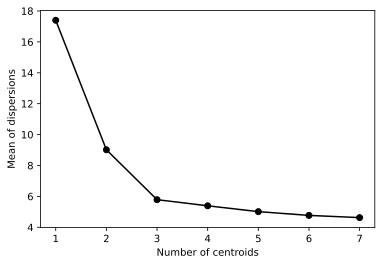

In [11]:
k_dispersion = []
for k in range(1, 8):
    centr = k_means(X=X, k=k)
    m_disp = cal_mean_dispersion(X, centroids=centr)
    k_dispersion.append([k, m_disp])

plt.plot([x[0] for x in k_dispersion], [x[1] for x in k_dispersion], 'ko-')
plt.xlabel("Number of centroids")
plt.ylabel("Mean of dispersions")

## 5. 应用：对鸢尾花聚类并预测

In [12]:
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.cluster import KMeans

In [13]:
d = datasets.load_iris()

In [14]:
rand_idx = np.arange(len(d['target']))
np.random.shuffle(rand_idx)

In [15]:
t_idx = rand_idx[:100]
v_idx = rand_idx[100:]

In [16]:
x_train, y_train = d['data'][t_idx], d['target'][t_idx]
x_test, y_test = d['data'][v_idx], d['target'][v_idx]

In [17]:
x_labels, y_labels = d['feature_names'], d['target_names']

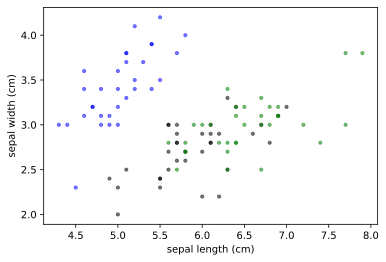

In [18]:
plt.figure()
plt.xlabel(x_labels[0])
plt.ylabel(x_labels[1])

x_0 = x_train[y_train == 0]
x_1 = x_train[y_train == 1]
x_2 = x_train[y_train == 2]

plt.scatter(x_0[:,0], x_0[:,1], s=10, c='b', marker='o', alpha=0.5)
plt.scatter(x_1[:,0], x_1[:,1], s=10, c='k', marker='o', alpha=0.5)
plt.scatter(x_2[:,0], x_2[:,1], s=10, c='g', marker='o', alpha=0.5)

In [19]:
x_train.shape

(100, 4)

In [20]:
cent = k_means(x_train, k=3)

In [21]:
pred = cate_k_means(x_train, centroids=cent)

In [22]:
np.sum((pred==1) == (y_train==1))

41

In [23]:
np.sum((pred==0) == (y_train==2))

41

In [24]:
np.sum((pred==2) == (y_train==0))


100

In [25]:
pred

array([1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 2, 0, 2, 1, 1,
       1, 2, 0, 2, 0, 2, 0, 1, 1, 1, 0, 2, 0, 1, 1, 2, 2, 1, 0, 0, 0, 0,
       2, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 0, 0, 0, 0, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0,
       0, 1, 0, 1, 1, 2, 1, 2, 1, 2, 2, 0])

In [26]:
y_train

array([2, 0, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2, 2,
       2, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1,
       0, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 2, 1, 2, 2, 0, 2, 0, 0, 1,
       1, 1, 1, 2, 2, 0, 2, 0, 2, 0, 0, 1])

- 使用Scikit-learn 的 KMeans聚类器

In [27]:
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=3)
clf.fit(x_train)

KMeans(n_clusters=3)

In [28]:
clf.fit_predict(x_train)

array([0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 2, 1, 0, 0,
       0, 1, 2, 1, 2, 1, 2, 0, 0, 0, 2, 1, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2,
       1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 2, 1, 2, 2, 2, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2,
       2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 2], dtype=int32)

## 课后练习
- 评估聚类效果：轮廓系数
轮廓系数（Silhouette Coefficient），是聚类效果好坏的一种评价方式。最早由 Peter J. Rousseeuw 在 1986 提出。 它结合内聚度和分离度两种因素。可以用来在相同原始数据的基础上用来评价不同算法、或者算法不同运行方式对聚类结果所产生的影响。
> 该系数的计算需计算任意两点之间的距离